# Chapter 7 集成学习与随机森林

8.导入 MNIST 数据（第三章中介绍），把它切分进一个训练集，一个验证集，和一个测试集（例如 50000 个实例进行训练，10000 个进行验证，10000 个进行测试）。然后训练多个分类器，例如一个随机森林分类器，一个 Extra-Tree 分类器和一个 SVM。接下来，尝试将它们组合成集成，使用软或硬投票分类器来胜过验证集上的所有集合。一旦找到了，就在测试集上实验。与单个分类器相比，它的性能有多好？

In [54]:
# Initilize the program by import some package and define some functions
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def save_fig(fig_id, tight_layout=True):  # Save the figure
    path = r'C:\Users\86181\Desktop\Access to CS\ML\sklearn and tensorflow\generated_image' + '\\' + fig_id + '.png'
    #os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    print("Saving figure", fig_id)

# 从以上的代码，我们可以定义上面的加强版，可以保存+展示图片
def save_and_show_figure(digit, image_name):
    digit_reshaped = digit.reshape(28,28)
    plt.imshow(digit_reshaped, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off') # 因为是显示数字，所以不需要轴了
    save_fig(image_name)
    plt.show()

# Draw the learning curve
def plot_learning_curve(model):
    train_errors, validation_errors = [], []
    for m in range(1000, 5001, 500): # This value depends on the dataset size
        model.fit(x_train[:m], y_train[:m])
        y_validation_pred = model.predict(x_validation[:m])
        y_train_pred = model.predict(x_train[:m])
        train_errors.append(mean_squared_error(y_train_pred, y_train[:m]))
        validation_errors.append(mean_squared_error(y_validation_pred, y_validation[:m]))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=3, label='train errors')
    plt.plot(np.sqrt(validation_errors), 'b-', linewidth=3, label='val errors')
    plt.xlabel('train dataset size', fontsize=15)
    plt.ylabel('RMSE', fontsize=15)
    plt.legend(loc='best')
    plt.show()

In [2]:
# Import the original dataset
original_data = pd.read_csv(r'D:\数据集\MNIST\mnist_784.csv')
original_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [3]:
# Split
y = original_data['class']
X = original_data.drop(['class'], axis=1)
X.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x_train, x_validation, x_test = X[:50000], X[50000:60000], X[60000:]
y_train, y_validation, y_test = y[:50000], y[50000:60000], y[60000:]

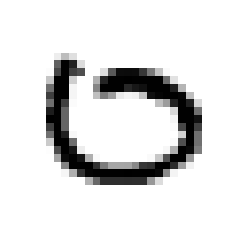

In [13]:
# Try to show the number
some_digit = X.values[29564]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

## 各种模型的测试

* 画出学习曲线
* 进行网格搜索，找出最优超参数

### 随机森林

In [29]:
from sklearn.ensemble import RandomForestClassifier
prev_rate = float('-inf')
best_estimator, best_min_sample_leaf, best_max_leaf_node = float('-inf'), float('-inf'), float('-inf')
estimators = [i for i in range(20,51,5)]
min_sample_leaf = [i for i in range(1, 10, 2)]
max_leaf_node = [i for i in range(10, 29, 3)]
# 网格搜索最优超参数
for i in estimators:
    for j in min_sample_leaf:
        for k in max_leaf_node:        
            rdf_clf = RandomForestClassifier(n_estimators=i, min_samples_leaf=j, max_leaf_nodes=k, n_jobs=6)
            rdf_clf = rdf_clf.fit(x_train, y_train)
            y_pred = rdf_clf.predict(x_validation)
            rate = sum(y_pred == y_validation)/len(y_pred)
            if rate > prev_rate:
                prev_rate = rate
                best_estimator = i
                best_min_sample_leaf = j
                best_max_leaf_node = k
print('The highest accurate rate is '+ str(prev_rate) +'\nthe hyperparameters are ' + str(best_estimator) + ', ' + str(best_min_sample_leaf) + ', ' + str(best_max_leaf_node) + ' respectively')

NameError: name 'best_max_leaf_nodeest' is not defined

In [31]:
print('The highest accurate rate is '+ str(prev_rate) +'\nthe hyperparameters are ' + str(best_estimator) + ', ' + str(best_min_sample_leaf) + ', ' + str(best_max_leaf_node) + ' respectively')

The highest accurate rate is 0.8787
the hyperparameters are 50, 9, 28 respectively


In [32]:
# According to the best hyperparameters, try to predict in the validation set
rdf_clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=9, max_leaf_nodes=28, n_jobs=6)
rdf_clf.fit(x_train, y_train)
y_pred = rdf_clf.predict(x_validation)
sum(y_pred == y_validation)/len(y_validation)

0.8656

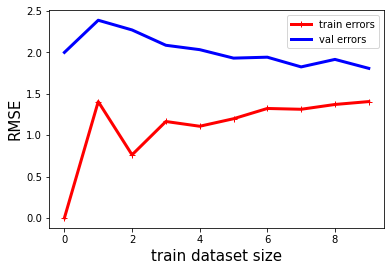

In [45]:
# Draw learning curve
plot_learning_curve(rdf_clf)

I think this model can not really satisfy me because 
* the train error seems an ascending trend rather than a decreaseing trend.
* the error of validation set always have a gap with train set, which may indicate that this model is not enough good

### KNeighbour

In [47]:
from sklearn.neighbors import KNeighborsClassifier
# Grid search the best hyperparameter
n_neighbor = [i for i in range(1,10)]
prev_rate, best_n_neighbor = float('-inf'), -1

for i in n_neighbor:
    knb_clf = KNeighborsClassifier(n_neighbors=i, n_jobs=7)
    knb_clf.fit(x_train, y_train)
    y_pred = knb_clf.predict(x_validation)
    rate = sum(y_pred == y_validation)/len(y_validation)
    if rate > prev_rate:
        prev_rate = rate
        best_n_neighbor = i
print('the best number of neighbor is ' + str(best_n_neighbor) + '\nthe accurate rate is ' + str(prev_rate))

the best number of neighbor is 4
the accurate rate is 0.9726


In [51]:
knb_clf = KNeighborsClassifier(n_neighbors=4, n_jobs=7)

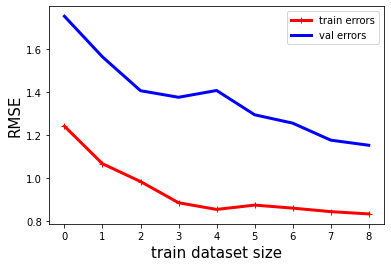

In [55]:
# Draw the learning curve
plot_learning_curve(knb_clf)

I think this model is really good, the accurate rate is 97.26%, and we can see that the validation error is descending